# Time series analysis with ARIMA and SARIMA

In [10]:
# import regular libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pymongo
import requests
from pandas.io.json import json_normalize
from statistics import stdev 
import json
import math

# from SciPy packages
from statsmodels.tsa.stattools import adfuller # adfuller test
from statsmodels.graphics.tsaplots import plot_acf # autocorellation plot
from statsmodels.graphics.tsaplots import plot_pacf # partial autocorellation plot

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

# statistics models
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# libraries to filter warnings in some algorithms
import warnings
warnings.filterwarnings("ignore")

## Load and Prepare Dataset

In [11]:
myclient = pymongo.MongoClient(host = '139.162.167.213:27017',username="mongo-naascap",password="n44$c4p")
cw = "?api_key=XRSFO6KHEQC87X8UOYZJ"

ts='6h'
market='coinbase-pro'
quote='btc'



def boxAsset(t,c):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    l=[word.split("_")[2] for word in bn if(word.startswith(t+"_"+c))]
    l.sort()
    return l

def getAssetClose(t,c,a):
    cbp=myclient["Spot"]
    db=cbp[t+"_"+c+"_"+a]
    db=pd.DataFrame(list(db.find({},{"_id":1,"close":1}).sort("_id",-1)))
    db.rename(columns={'close':a},inplace=True)
    db.index=[(datetime.fromtimestamp(i)) for i in db._id]
    return db[a]


def getMarketCloses(ts):
    assets=boxAsset(ts,market)
    closes=[getAssetClose(ts,market,asset) for asset in assets]
    data = pd.concat(closes,join='outer',axis=1,sort=False)
    date_format = "%d/%m/%Y"
    date = datetime.strptime('01/01/2020', date_format)
    data=data[[date<=dates for dates in data.index]]
    return data


def getColumns(TT):
    df=pd.DataFrame([TT.columns,TT.columns]).T.set_axis(['id', 'name'], axis=1, inplace=False)
    L=[0]*(len(df))
    for i in (range(len(df))):
        L[i]={'id':df["id"][i],'name':df["name"][i]}
    return L
 
def listToDropDown(l):
    df=pd.DataFrame([l,l]).T.set_axis(['Value', 'Label'], axis=1, inplace=False)
    df=df.sort_values("Value").reset_index()
    L=[0]*len(df)
    for i in range(len(df)):
        L[i]={'label':df["Label"][i],'value':df["Value"][i]}
    return L




def TableBaseFromSymbol():
    URL="https://api.cryptowat.ch/pairs"
    res = requests.get(URL + cw)
    T=json_normalize(json.loads(res.content.decode('utf-8'))["result"])
    T=T.loc[:,["symbol","base.symbol","quote.symbol"]]
    return T
T = TableBaseFromSymbol()
def BaseFromSymbol(T,sym):
    if(sym in list(T.symbol)):
        return T["base.symbol"][T.symbol==sym].iloc[0]

def QuoteFromSymbol(T,sym):
    if(sym in list(T.symbol)):
        return T["quote.symbol"][T.symbol==sym].iloc[0]

def getAllAssetCloseByTime(t):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    bn=[word for word in bn if(word.split("_")[1]== market and word.split("_")[0]==t)]
    df=pd.DataFrame()
    l2=[]
    l=list(set([word.split("_")[2] for word in bn]))
    TT=list(set([BaseFromSymbol(T,i) for i in l if(QuoteFromSymbol(T,i)) == quote]))
    for asset in TT:
        l1=[word for word in bn if(BaseFromSymbol(T,word.split("_")[2])==asset and QuoteFromSymbol(T,word.split("_")[2]) == quote)]
        rr=[pd.DataFrame(list(cbp[i].find({},{ "_id": 1, "close": 1})),index=pd.DataFrame(list(cbp[i].find({},{ "_id": 1})))._id) for i in l1]
        data = pd.concat([i["close"] for i in rr],join='outer',axis=1,sort=False)
        l2.append(data.mean(axis=1))

    df=pd.concat(l2,axis=1)
    df.columns=(TT)
    df.index=[(datetime.fromtimestamp(i)) for i in df.index]
    df = df.fillna(method = "ffill")
    
    return df

def getAllAssetVolumeByTime(t):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    bn=[word for word in bn if(word.split("_")[1]== market and word.split("_")[0]==t)]
    df=pd.DataFrame()
    l2=[]
    l=list(set([word.split("_")[2] for word in bn]))
    TT=list(set([BaseFromSymbol(T,i) for i in l if(QuoteFromSymbol(T,i)) == quote]))
    for asset in TT:
        l1=[word for word in bn if(BaseFromSymbol(T,word.split("_")[2])==asset and QuoteFromSymbol(T,word.split("_")[2]) == quote)]
        rr=[pd.DataFrame(list(cbp[i].find({},{ "_id": 1, "volume_quote": 1})),index=pd.DataFrame(list(cbp[i].find({},{ "_id": 1})))._id) for i in l1]
        data = pd.concat([i["volume_quote"] for i in rr],join='outer',axis=1,sort=False)
        l2.append(data.mean(axis=1))

    df=pd.concat(l2,axis=1)
    df.columns=(TT)
    df.index=[(datetime.fromtimestamp(i)) for i in df.index]
    df = df.fillna(0)
    
    return df


In [12]:
market='coinbase-pro' #'kraken'
quote='usd' #'btc'
ts='1d' # '5m' '2h' '6h' '12h' '1d'
df=getAllAssetCloseByTime(ts)
df1=getAllAssetVolumeByTime('1d') 

In [13]:
df.tail()

,dai,algo,ltc,nmr,oxt,dash,eos,atom,eth,omg,...,knc,etc,zrx,rep,xtz,comp,btc,link,bch,xrp
2020-09-08 01:00:00,1.019672,0.3728,47.83,38.2915,0.3373,69.607,2.887,5.086,349.13,3.8241,...,1.2949,5.740,0.479448,17.39,2.5120,171.40,10222.63,12.59319,228.61,0.2388
2020-09-09 01:00:00,1.025348,0.3672,48.54,36.8508,0.3352,75.470,2.841,4.955,349.63,3.6162,...,1.2265,5.793,0.454064,16.81,2.5201,179.24,10344.98,12.51014,227.67,0.2417
2020-09-10 01:00:00,1.021563,0.4188,48.25,37.1212,0.3490,75.865,2.781,5.385,354.84,3.6440,...,1.2303,5.636,0.467675,16.94,2.5487,181.84,10279.75,12.38302,225.50,0.2406
2020-09-11 01:00:00,1.033173,0.4106,48.37,36.3880,0.3512,75.967,2.766,5.308,366.14,3.8644,...,1.2269,5.621,0.465700,16.90,2.5596,172.26,10308.30,12.47000,226.06,0.2421
2020-09-12 01:00:00,1.035423,0.4079,48.65,36.5304,0.3558,76.644,2.781,5.325,370.61,3.8488,...,1.2406,5.661,0.476219,16.68,2.5811,173.56,10358.01,12.55072,227.01,0.2434


In [14]:
df1.tail()

,dai,algo,ltc,nmr,oxt,dash,eos,atom,eth,omg,...,knc,etc,zrx,rep,xtz,comp,btc,link,bch,xrp
2020-09-08 01:00:00,3.140470e+05,1.295425e+06,8.623307e+05,150831.032129,1.120047e+06,43326.782064,9.851579e+04,2.469572e+05,8.406784e+06,1.175022e+06,...,9.339515e+05,145975.352240,6.154111e+05,46419.892948,1.283517e+06,9.967692e+05,9.923039e+06,1.175999e+07,7.750499e+05,1.917426e+06
2020-09-09 01:00:00,1.675258e+05,2.805708e+05,2.861999e+05,56996.377093,2.332074e+05,58675.462957,6.071682e+04,6.834835e+04,5.588346e+06,5.446918e+05,...,1.258419e+05,16545.642032,9.508218e+04,31397.419326,2.086521e+05,3.385864e+05,7.416860e+06,2.648246e+06,3.319452e+05,4.144094e+05
2020-09-10 01:00:00,1.592770e+06,1.473162e+07,4.891587e+06,533278.100098,4.117442e+06,491281.713939,1.072104e+06,2.674876e+06,4.761197e+07,8.911870e+06,...,2.445544e+06,526228.724388,1.208039e+06,464416.328011,5.114934e+06,2.385073e+06,8.292088e+07,2.888989e+07,3.487165e+06,8.254004e+06
2020-09-11 01:00:00,2.270688e+06,1.767153e+07,5.514637e+06,843991.844074,5.317704e+06,354448.428164,1.090775e+06,1.481875e+06,7.424194e+07,1.441989e+07,...,4.498740e+06,821383.016116,2.067787e+06,470407.884118,4.734578e+06,2.916679e+06,1.060016e+08,4.461720e+07,3.805004e+06,1.154592e+07
2020-09-12 01:00:00,2.895372e+06,1.749656e+05,1.471721e+05,501770.541020,6.530216e+04,22225.356481,1.499479e+04,3.508021e+04,1.422747e+06,6.520381e+06,...,3.055789e+04,10816.376658,6.116874e+04,3472.645922,2.694686e+05,4.833785e+06,1.827527e+06,5.629779e+05,1.362620e+05,3.076889e+05


In [15]:
df1.size

47288

In [16]:
def get_Volume_data(df1,ch):
    df=df1[[ch]]
    x=len(df)%7 
    df=df.drop(df.index[0:x])
    return df

In [17]:
dataset= get_Volume_data(df1,'btc')

In [18]:
dataset.head()

,btc
2015-02-01 01:00:00,0.0
2015-02-02 01:00:00,0.0
2015-02-03 01:00:00,0.0
2015-02-04 01:00:00,0.0
2015-02-05 01:00:00,0.0


In [19]:
dataset.size

2051

In [47]:
dataset.to_csv('data.csv')

In [20]:
# fill all NaN values with some particular value
dataset.fillna(0, inplace=True)

name_coin = 'btc'

# look at the values of the dataset
values = dataset.values

# Counting number of days per year
count_yearly_days =dataset[name_coin].resample("Y").count()
print(count_yearly_days)
print()

# summarize dataset
print("Shape of the dataset :", dataset.shape)
print()
print("First rows of the dataset :", dataset.head())
print()
print("Statistics on the dataset :",dataset.describe())



# definition of a series from the values of the dataframe
series = pd.Series(values[:,0])
series.index = dataset.index
series.index.name = 'date'


2015-12-31    334
2016-12-31    366
2017-12-31    365
2018-12-31    365
2019-12-31    365
2020-12-31    256
Freq: A-DEC, Name: btc, dtype: int64

Shape of the dataset : (2051, 1)

First rows of the dataset :                      btc
2015-02-01 01:00:00  0.0
2015-02-02 01:00:00  0.0
2015-02-03 01:00:00  0.0
2015-02-04 01:00:00  0.0
2015-02-05 01:00:00  0.0

Statistics on the dataset :                 btc
count  2.051000e+03
mean   5.880900e+07
std    1.108376e+08
min    0.000000e+00
25%    0.000000e+00
50%    3.304930e+05
75%    7.698646e+07
max    1.396135e+09


## Time Series Data Visualization

<p style="text-align: justify">Then a series of curves can be plotted to visualize the dataset and understand if the data answers to a particular behaviour. The first type of plot visualization for time series is the line plot, which is done below for the evolution of the price with time. It can be seen that the price increased substantially since 2017, which is the year where most people became aware of cryptocurrencies. To have a better insight of the price evolution, we can plot the time series after taking its logarithm transformation. A <em>log</em> transformation is often used in order to turn a time series <a href="https://en.wikipedia.org/wiki/Stationary_process">stationary</a>, which is often required for analysis. In our case, the time series is not stationary which may require some differencing, and transformation operations.</p>


<p style="text-align: justify">Another type of plot that is useful to summarize the distribution of observations is the box and whisker plot. From the whiskers plot below, we can see the disparity in data with years. The first 3 years have much smaller values, and are almost insignificant compared to the values in 2017 and 2018. In some analysis, the first years would be considered as outliers, however here as the data available is not enough it is important to keep these years. Also, as seen on the log-log plot of the time series, some recurrent behaviour is seen, such as cycles with a big increase of the coin value in 2017 as explained above.</p>


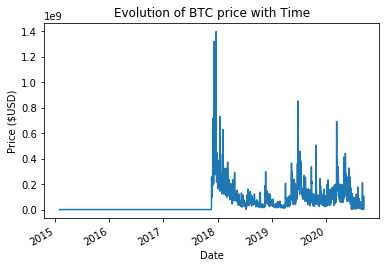

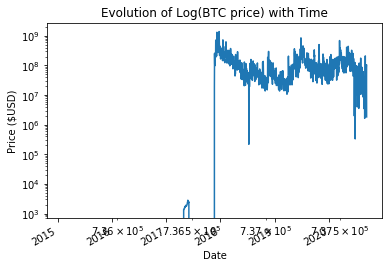

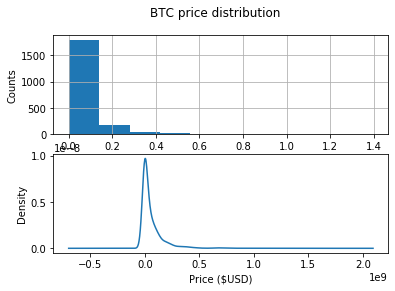

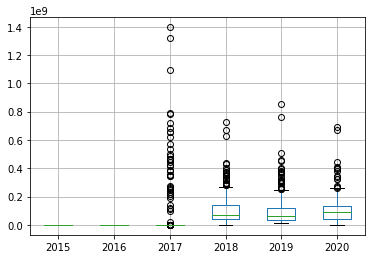

In [50]:

# plot the series against time
series.plot()
plt.ylabel('Price ($USD)')
plt.xlabel('Date')
plt.title('Evolution of BTC price with Time')
plt.show()

# plot the log of the time series against time
series.plot(loglog=True)
plt.ylabel('Price ($USD)')
plt.xlabel('Date')
plt.title('Evolution of Log(BTC price) with Time')
plt.show()

# density plot
plt.figure()
plt.suptitle('BTC price distribution')
plt.subplot(211)
plt.xlabel('Price ($USD)')
plt.ylabel('Counts')
series.hist()
plt.subplot(212)
plt.xlabel('Price ($USD)')
series.plot(kind='kde')
plt.show()

# Box and Whisker plots
groups = series['2013':'2020'].groupby(pd.Grouper(freq='Y'))

years_df = list()
for name, group in groups:
    df = pd.DataFrame()
    df[name.year] = group.values
    years_df.append(df)
# concatenate the columns of the different coins and save the dataset to a csv file
years = pd.concat(years_df, axis = 1, sort=False)

years.boxplot()
plt.show()

In [52]:
years

,2015,2016,2017,2018,2019,2020
0,0.0,0.0,0.0,2.504745e+08,4.783497e+07,4.855759e+07
1,0.0,0.0,0.0,1.649921e+08,4.012372e+07,2.411076e+07
2,0.0,0.0,0.0,3.732950e+08,3.827962e+07,5.624828e+07
3,0.0,0.0,0.0,2.673920e+08,3.568759e+07,1.015992e+08
4,0.0,0.0,0.0,2.960367e+08,3.491539e+07,3.473288e+07
...,...,...,...,...,...,...
361,NaN,0.0,381219940.0,4.957087e+07,6.098717e+07,NaN
362,NaN,0.0,445687140.0,6.352086e+07,3.374984e+07,NaN
363,NaN,0.0,269485500.0,3.776146e+07,4.853371e+07,NaN
364,NaN,0.0,384533860.0,3.307405e+07,5.351703e+07,NaN


## Autocorrelation Analysis


<p style="text-align: justify">We can clearly see a familiar autoregression pattern across the two plots. This pattern is comprised of two elements:</p>

<ul>
<li><strong>ACF</strong>: A large number of significant lag observations that slowly degrade as the lag increases.</li>
<li><strong>PACF</strong>: A few significant lag observations that abruptly drop as the lag increases.</li>
</ul>

<p style="text-align: justify">The ACF plot indicates that there is a strong autocorrelation component, whereas the PACF plot indicates that this component is distinct for the first approximately two lag observations. However, most of the lags are out of the interval of confidence, and it is difficult to characterize the current plot.</p>

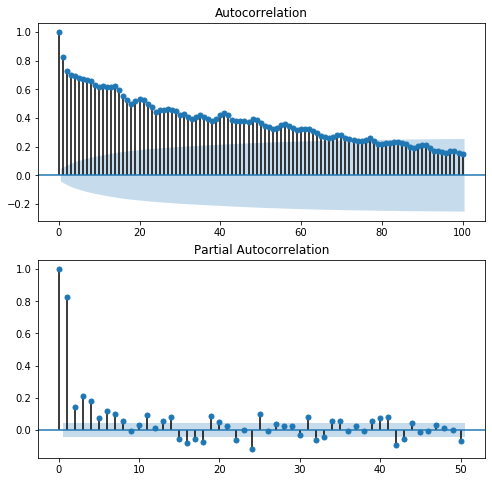

In [22]:
# plot Autocorrelation and Partial ACF plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
plot_acf(series, lags =100, ax = ax1)
plot_pacf(series, lags =50, ax = ax2)
plt.show()

## Augmented Dickey-Fuller test


<p style="text-align: justify">The <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">Augmented Dickey-Fuller test</a> is a type of statistical test called a <a href="https://en.wikipedia.org/wiki/Unit_root_test">unit root test</a>.</p>

<p style="text-align: justify">The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.</p>



<ul>
<li><strong>Null Hypothesis (H0)</strong>: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.</li>
<li><strong>Alternate Hypothesis (H1)</strong>: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.</li>
</ul>

<ul>
<li><strong>p-value &gt; 0.05</strong>: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.</li>
<li><strong>p-value &lt;= 0.05</strong>: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.</li>
</ul>


In [23]:
# check if stationary
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.209850
p-value: 0.000634
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




<p style="text-align: justify">The results show that the test statistic value -4.179191 is smaller than the critical value at 5% of -2.863. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke).</p>

<p style="text-align: justify">Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. Interestingly, the current time series can be considered stationary, when it doesn't seem to be so. This implies that no differencing operation will be required for analysis with the different models.</p>

## Evaluation metric

<p style="text-align: justify">A forecast will be comprised of seven values, one for each day of the week ahead.</p>

<p style="text-align: justify">Both <a href="https://en.wikipedia.org/wiki/Root-mean-square_deviation">Root Mean Squared Error (RMSE)</a> and <a href="https://en.wikipedia.org/wiki/Mean_absolute_error">Mean Absolute Error (MAE)</a> can be used to quantify the errors in price prediction (USD), although RMSE is more commonly used and will be adopted. Unlike MAE, RMSE is more punishing of forecast errors.</p>
<p style="text-align: justify">The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7. In this way, we can see how the chosen algorithms perform on the predictions at a particular day of the week. The cryptocurrency market is quite volatile, and may have a different behaviour depending on the period of the week (weekdays or weekend for instance).</p>
<p style="text-align: justify">As a short-cut, it may be useful to summarize the performance of a model using a single score in order to help in model selection. One possible score that could be used would be the RMSE across all forecast days.</p>

<p style="text-align: justify">The function <i>evaluate_forecasts()</i> below will implement this behavior and return the performance of a model based on multiple seven-day forecasts.</p>


In [24]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

<p style="text-align: justify">Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day.</p>

## Train and Test Sets

<p style="text-align: justify">We will split the data into standard weeks, working backwards from the test dataset. This gives 180 weeks of data for the training set and 109 weeks (763 days) for the testing set.</p>

<p style="text-align: justify">The function <em>split_dataset()</em> below splits the daily data into train and test sets and organizes each into standard weeks. The "<i>n_test</i>" argument corresponds to the number of days (714 in this study), to cut the data backwards.</p>

In [25]:
# split a univariate dataset into train/test sets
def split_dataset(data, n_test):
    # split into standard weeks
    train, test = data[0:-n_test], data[-n_test:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

# testing the procedure on the current data
n_test=(math.floor(0.4*(len(dataset)/7)))*7 # number of days to split the dataset in weekly windows
train, test = split_dataset(values, n_test)
# validate train data
print("Training dataset shape :", train.shape)
print("First row :", train[0, 0, :], "; Last row :" ,train[-1, -1, :])
# validate test
print("Testing dataset shape :", test.shape)
print("First row :", test[0, 0, :], "; Last row :" ,test[-1, -1, :])

Training dataset shape : (176, 7, 1)
First row : [0.] ; Last row : [45929730.]
Testing dataset shape : (117, 7, 1)
First row : [29184908.] ; Last row : [1827527.35050667]


## Walk-forward validation

<p style="text-align: justify">Models will be evaluated using a scheme called <a href="https://en.wikipedia.org/wiki/Walk_forward_optimization">walk-forward validation</a>.</p>

<p style="text-align: justify">This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data.</p>

<p style="text-align: justify">The forecasts made by the model are then evaluated against the test dataset using the previously defined <em>evaluate_forecasts()</em> function.</p>

In [26]:
def evaluate_model(model_func, train, test, *args):
    #history of weekly data
    history = [x for x in train]
    #walk forward validation
    predictions = list()
    for i in range(len(test)):
    #weekly prediction
        y_hat_seq = model_func(history, *args)
    #store the preditions
        predictions.append(y_hat_seq)
    #update history data
        history.append(test[i,:])
    predictions = np.array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

<p style="text-align: justify">Once we have the evaluation for a model, we can summarize the performance.</p>

<p style="text-align: justify">The function below named <em>summarize_scores()</em> will display the performance of a model as a single line for easy comparison with other models.</p>

In [27]:
#Summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: Total RMSE --> [%.3f]; Daily RMSE: %s' % (name, score, s_scores))

## Develop an Autoregression Model

<p style="text-align: justify">The <em>to_series()</em> function below will take the multivariate data divided into weekly windows and will return a single univariate time series.</p>

In [28]:
# convert windows of weekly multivariate data into a series of closing price
def to_series(data):
    # extract just the price of XRP from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = np.array(series).flatten()
    return series

In [38]:
# Arima forecast for weekly prediction
def arima_forecast(history, arima_order):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=arima_order)
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

<p style="text-align: justify">The seasonal ARIMA model <a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMA</a>, can also be implemented in a similar way as the ARIMA model. The <em>Sarima_forecast</em> function below implements the same procedure as above, with the <em>"config"</em> argument defining the configuration of the chosen SARIMA model. The seasonal ARIMA model takes more parameters than the regular ARIMA model, to characterize some seasonal trends that might be present inside the dataset.</p>

In [39]:
# Sarima forecast for weekly prediction
def Sarima_forecast(history, config):
    order, sorder, trend = config
    # convert history into a univariate series
    series = to_series(history)
    # define model
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=True, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

<p style="text-align: justify">A grid search with hyperparameters has been carried out to find the most suitable ARIMA and SARIMA models for the current study. We find that <b>ARIMA(1,0,0)</b> and <b>SARIMA((0,1,0),(0,0,0,0),'n')</b> give the best results out of the different parameters tested, in this configuration.</p> 

In [40]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
models['Sarima'] = Sarima_forecast

# define both parameters for the 2 models
arima_order = (1,0,0)
config_sarima = (0,1,0),(0,0,0,0),'n'

# list creation to store the parameters
orders = list()
orders.extend([arima_order, config_sarima])

# list containing the days of the week for plot on a particular day
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']

<p style="text-align: justify">After defining the different functions, it is now possible to evaluate the different algorithms, summarizing their scores and plotting the RMSE for each day of the week. The function <em>evaluate_algorithms()</em> below implements this procedure by looping over the dictionary of models, and saving the predictions of each model in a list of results, to be used for plots afterwards.</p>

In [41]:
# evaluate each model
def evaluate_algorithms(models, orders):
    prediction_simulations = list()
    for (name, func), order in zip(models.items(), orders): # loop on dictionary items and list orders at same time
        # evaluate and get scores
        score, scores, predictions = evaluate_model(func, train, test, order)
        # summarize scores
        summarize_scores(name, score, scores)
        # plot scores
        plt.plot(days, scores, marker='o', label=name)
        # append the simulation results in a list
        prediction_simulations.append(predictions)
    # plot properties and showing
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    return prediction_simulations

In [42]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(models, train, test, prediction_simulations, colors ,n_test):
    # reshape train and tests set --> flattened for each feature
    train = np.reshape(train, (train.shape[0]*train.shape[1],train.shape[2]))
    test = np.reshape(test, (test.shape[0]*test.shape[1],test.shape[2]))
    
    #plt.plot(train) # plot training dataset
    plt.plot([None for i in train] + [x for x in test[:,0]], color = 'green', label="testing set")
    
    for i, (name, model), color in zip(range(len(prediction_simulations)), models.items(), colors): # looping over all results and arguments together 
        predictions = np.array(prediction_simulations[i]).flatten() # flatten predictions
        plt.plot([None for i in train] + [i for i in predictions] , color=color, label=name)
     
    # define different properties on the plot
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.suptitle("Evolution of price with time",fontsize=18, fontweight='bold')
    plt.legend()
    # show the plot
    plt.show()

    
residuals_model = dict() # initialize dictionary to store dataframes of residuals


def plot_residuals(models, test, prediction_simulations, colors,n_test):
    
    
    
    # redefine train and test set without the weekly reshaping
    test = np.reshape(test, (test.shape[0]*test.shape[1],test.shape[2])) # flatten test matrix
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (8,8)) # figure creation with 2 subplots
    
    for i, (name, model), color in zip(range(len(prediction_simulations)), models.items(), colors): # looping over all results and arguments together
        predictions = np.array(prediction_simulations[i]).flatten() # flatten predictions
        residuals = [test[i,0] - predictions[i] for i in range(len(test))] # list comprehension to calculate residuals
        residuals = pd.DataFrame(residuals) # creates a dataframe
        residuals.plot(kind = 'line', ax = ax1, color=color) # line plot
        residuals.hist(ax = ax2, bins = 30, color=color) # histogram
        residuals.plot(kind = 'kde', ax = ax3, color=color) # kernel density estimation
        
        residuals_model[name] = residuals # store the residuals dataframe inside the dictionary
        
    # define different properties on the plot
    ax1.set_ylabel('Residual value ($)')
    ax1.set_xlabel('Time (days)')
    ax2.set_ylabel('Counts')
    plt.xlabel('Price ($)')
    ax1.legend(['arima','Sarima'])
    ax2.legend(['arima','Sarima'])
    ax3.legend(['arima','Sarima'])
    fig.suptitle(r'Evolution of the residuals', fontsize=18, fontweight='bold', y=0.92)
    # show the plot
    plt.show()

<p style="text-align: justify">The script below defines all the parameters necessary to run the simulation, split the dataset into a training and testing dataset, and call the <em>evaluate_algorithms()</em> function to make predictions on the testing dataset with ARIMA and SARIMA models.</p>

arima: Total RMSE --> [81790157.865]; Daily RMSE: 68310766.0, 53099673.1, 56190306.0, 73613032.5, 102688526.9, 113412885.4, 85777784.3
Sarima: Total RMSE --> [86137462.372]; Daily RMSE: 78329931.8, 69345879.4, 59320281.4, 80997112.5, 101979916.3, 110486585.0, 91140501.1


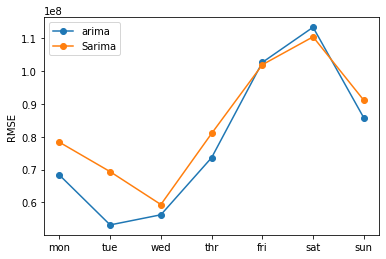

In [43]:
n_test =(math.floor(0.4*(len(dataset)/7)))*7 
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
models['Sarima'] = Sarima_forecast

arima_order = (1,0,0)
config_sarima = (0,1,0),(0,0,0,0),'n'

orders = list()
orders.extend([arima_order, config_sarima])


# Creating a list of colors to be passed as arguments for the plots
colors = list()
colors.extend(['red','blue'])

#for n_test in n_tests:
train, test = split_dataset(dataset.values, n_test)

# evaluate the different algorithms defined in "models" dictionary
prediction_simulations = evaluate_algorithms(models, orders)

<p style="text-align: justify">As seen on the figure above, and the printed scores, the ARIMA and SARIMA models performs similarly. This is expected, considering that we are using rolling windows of 7 days in which, a seasonal pattern should hardly exist. Considering the training and testing dataset as a whole for instance would lead to different results as seasonal patterns do exist, especially when considering cryptocurrencies or other financial assets.</p>

<p style="text-align: justify">The RMSE error also increases as the week goes on. Indeed, considering the models are autoregressive with a lag of 1, the error gradually increases through the week depending on the evolution of the price compared to monday.</p>



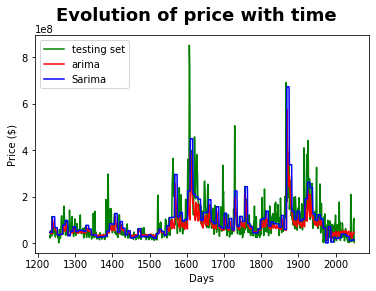

In [44]:
plot_forecasts(models, train, test, prediction_simulations, colors ,n_test)

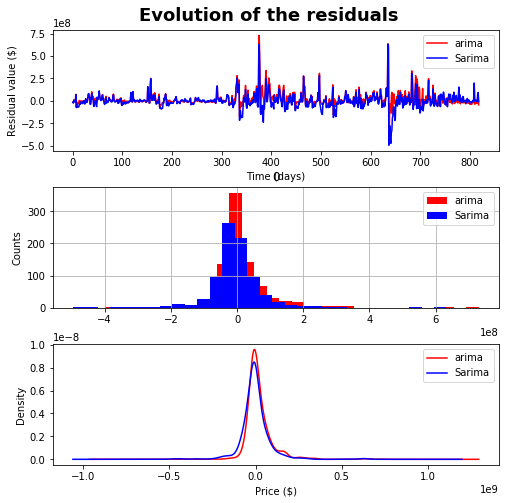

In [45]:
plot_residuals(models, test, prediction_simulations, colors,n_test)

<p style="text-align: justify">The residuals evolution and statistics, shows a Gaussian distribution which located close to a mean of 0, which is something we need to achieve while considering the residuals of a prediction.</p>

<p style="text-align: justify">In the next cell, different statistics of the residuals are printed for both models. We can see, that despite having a mean close to 0, the standard deviation for both models is too high in comparison of the values at stake. One main reason is due to the big jump in  price after 1600 days (in 2017), which created some disruption in the models with some high residual values. 

In [46]:
print('ARIMA stats :', residuals_model['arima'].describe())
print()
print('SARIMA stats :', residuals_model['Sarima'].describe())

ARIMA stats :                   0
count  8.190000e+02
mean   1.902219e+07
std    7.959599e+07
min   -3.995636e+08
25%   -1.767344e+07
50%    1.904690e+05
75%    3.658838e+07
max    7.304462e+08

SARIMA stats :                   0
count  8.190000e+02
mean  -2.359479e+06
std    8.615776e+07
min   -4.961859e+08
25%   -3.369680e+07
50%   -7.486193e+06
75%    2.052239e+07
max    6.330691e+08
